###  Libraries

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Rings import Rings
from Common_Modules.Evaluation import Evaluator
from Common_Modules.Graph import Graph

### Global Variables

In [12]:
seed = 42
evaluator = Evaluator()
graph_is_enabled = False
kMeans_is_enabled = False
kernelKMeans_is_enabled = False
kernelKMeansPP_is_enabled = True
globalKernelKMeans_is_enabled = True
globalKernelKMeansPP_is_enabled = True

### Load Dataset

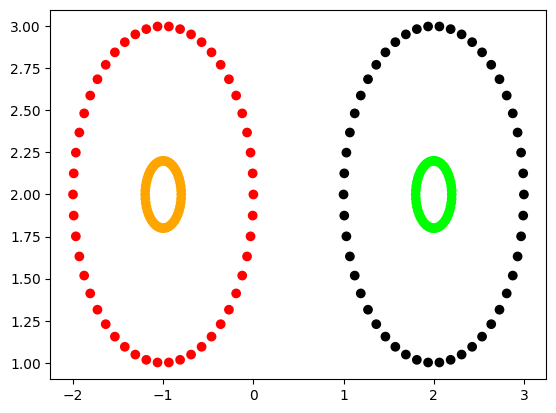

In [13]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']
# centers_coordinates = [(-1, 2), (2, 2), (2, 5), (2, -1), (5, 2), (6, 6), (-2, 6), (2, 8), (6, -2), (2, -4), (-2, -2)]
centers_coordinates = [(-1, 2), (2, 2)]
rings = Rings(colors)
X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=100, factor=0.2, noise=0.0)

K = 2 * len(centers_coordinates)
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)

In [14]:
if (False):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    class Rings:
        def __init__(self, colors, seed=42):
            self.colors = colors
            self.seed = seed

        def plot(self, X, labels_):
            plt.scatter(X[:, 0], X[:, 1], c=labels_, cmap=ListedColormap(self.colors))
            plt.show()

        def move_rings(self, center_coordinates, X):
            X[:, 0] += center_coordinates[0]
            X[:, 1] += center_coordinates[1]
            return X

        def generate_circle(self, n_samples, radius, noise):
            angles = np.linspace(0, 2 * np.pi, n_samples, endpoint=False)
            X = np.c_[radius * np.cos(angles), radius * np.sin(angles)]
            X += noise * np.random.randn(n_samples, 2)
            return X

        def make_concentric_rings(self, centers_coordinates, n_samples=300, radii=[1, 2, 3], noise=0.05):
            pairs = []
            label = 0

            for center_coordinates in centers_coordinates:
                X_list, y_list = [], []
                for i, radius in enumerate(radii):
                    X = self.generate_circle(n_samples // len(radii), radius, noise)
                    y = np.full(X.shape[0], i)  # Assign unique label for each ring
                    X_list.append(X)
                    y_list.append(y)

                # Concatenate all rings
                X = np.concatenate(X_list)
                y = np.concatenate(y_list)

                X = self.move_rings(center_coordinates, X)

                pairs.append((X, y))
                label += len(radii)

            return self.concatenate_pairs(pairs)

        def concatenate_pairs(self, pairs):
            X = np.concatenate([X for X, _ in pairs])
            y = np.concatenate([y for _, y in pairs])
            self.plot(X, y)
            return X, y

    # Example usage:
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    rings = Rings(colors=colors)

    # Define the center for the single set of three concentric rings
    centers_coordinates = [(0, 0)]

    # Generate and plot the rings
    X, y = rings.make_concentric_rings(centers_coordinates=centers_coordinates, n_samples=150, radii=[1, 10, 25], noise=0)

    K = 3 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='sigmoid')
    print(X)

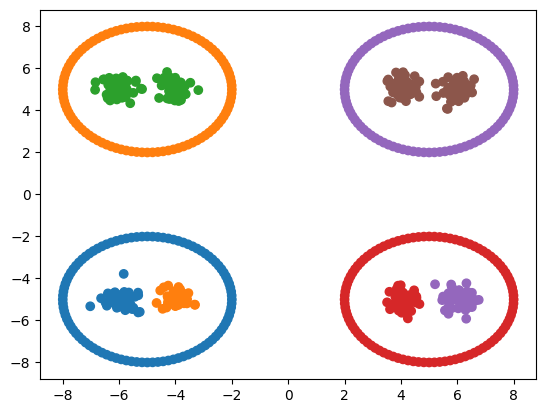

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics.pairwise import pairwise_kernels
import copy

class Rings:
    def __init__(self, colors, seed=42):
        self.colors = colors
        self.seed = seed
        np.random.seed(self.seed)

    def plot(self, X, labels_):
        plt.scatter(X[:, 0], X[:, 1], c=labels_, cmap=ListedColormap(self.colors))
        plt.show()

    def generate_circle(self, n_samples, radius, noise):
        angles = np.linspace(0, 2 * np.pi, n_samples, endpoint=False)
        X = np.c_[radius * np.cos(angles), radius * np.sin(angles)]
        X += noise * np.random.randn(n_samples, 2)
        return X

    def generate_gaussians(self, n_samples, means, cov, labels):
        X = np.vstack([np.random.multivariate_normal(mean, cov, n_samples) for mean in means])
        y = np.hstack([[label]*n_samples for label in labels])
        return X, y

    def make_multiple_rings_with_gaussians(self, centers_coordinates, n_samples=100, radius=10, noise=0.05, gaussian_samples=50):
        X_list, y_list = [], []
        label_offset = 0
        
        for center_coordinates in centers_coordinates:
            # Generate ring
            X_ring = self.generate_circle(n_samples, radius, noise)
            y_ring = np.full(X_ring.shape[0], label_offset)  # Label for the ring
            X_ring = self.move_rings(center_coordinates, X_ring)
            X_list.append(X_ring)
            y_list.append(y_ring)
            
            # Generate 2 Gaussians inside the ring
            gaussians_X, gaussians_y = self.generate_gaussians(
                gaussian_samples,
                means=[(center_coordinates[0] - 1, center_coordinates[1]), 
                       (center_coordinates[0] + 1, center_coordinates[1])],  # Centered near the ring's center
                cov=[[0.1, 0], [0, 0.1]],  # Covariance matrix
                labels=[label_offset + 1, label_offset + 2]  # Unique labels for Gaussians
            )

            X_list.append(gaussians_X)
            y_list.append(gaussians_y)

            label_offset = label_offset + 3
        # Concatenate all parts
        X = np.concatenate(X_list)
        y = np.concatenate(y_list)

        self.plot(X, y)
        return X, y

    def move_rings(self, center_coordinates, X):
        X[:, 0] += center_coordinates[0]
        X[:, 1] += center_coordinates[1]
        return X

# Usage example
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
rings = Rings(colors)
centers_coordinates = [(-5, -5), (-5, 5), (5, -5), (5, 5)]
X, y = rings.make_multiple_rings_with_gaussians(centers_coordinates, n_samples=100, radius=3, noise=0.0, gaussian_samples=50)

K = 3 * len(centers_coordinates)
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=0.5)

In [16]:
if (False):
    import scipy.io
    X_mat = scipy.io.loadmat('3circles_dataset.mat')
    X = np.array(X_mat['Dataset'])
    kernel_matrix_mat = scipy.io.loadmat('3circles_kernel_matrix.mat')
    kernel_matrix = np.array(kernel_matrix_mat['K'])
    y = np.loadtxt('array.txt').astype(int)
    print(y)

### Create Graph

In [17]:
if(graph_is_enabled):
    # Number of nodes per community
    n_nodes_per_community = 10

    # Number of communities
    K = n_communities = 10
    
    # Probability of intra-community edge
    p_intra = 1  
    
    # Probability of inter-community edge
    p_inter = 0.01  

    graph = Graph(n_communities, n_nodes_per_community, p_intra, p_inter, colors)
    graph.create_adj_matrix()
    kernel_matrix = graph.adj_matrix = pairwise_kernels(graph.adj_matrix, graph.adj_matrix, metric='linear')
    graph.create_kernel_matrix_from_adj_matrix()

### kMeans

In [18]:
if(kMeans_is_enabled):
    kmeans = KMeans(n_clusters=K).fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
    evaluator.print_evaluation()
    rings.plot(X, kmeans.labels_)

### Kernel kMeans

In [19]:
if(kernelKMeans_is_enabled):
    kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
    evaluator.print_evaluation()
    rings.plot(X, kernel_kmeans.labels_)

### Kernel kMeans++

Execution 0 of Kernel k-Means
Finished in Iter: 13 MSE: 460.6608
Execution 0 of Kernel k-Means MSE: 460.6607702057453 in 0.020159006118774414s
Execution 1 of Kernel k-Means
Finished in Iter: 8 MSE: 490.2904
Execution 1 of Kernel k-Means MSE: 490.2904254366419 in 0.0s
Execution 2 of Kernel k-Means
Finished in Iter: 12 MSE: 492.5388
Execution 2 of Kernel k-Means MSE: 492.5387686677229 in 0.01353311538696289s
Execution 3 of Kernel k-Means
Finished in Iter: 8 MSE: 460.7172
Execution 3 of Kernel k-Means MSE: 460.7172382337498 in 0.01785731315612793s
Execution 4 of Kernel k-Means
Finished in Iter: 12 MSE: 488.9166
Execution 4 of Kernel k-Means MSE: 488.9165721323898 in 0.016984939575195312s
Execution 5 of Kernel k-Means
Finished in Iter: 8 MSE: 460.9936
Execution 5 of Kernel k-Means MSE: 460.99355907631224 in 0.0s
Execution 6 of Kernel k-Means
Finished in Iter: 8 MSE: 491.6454
Execution 6 of Kernel k-Means MSE: 491.64538409075726 in 0.016687870025634766s
Execution 7 of Kernel k-Means
Finishe

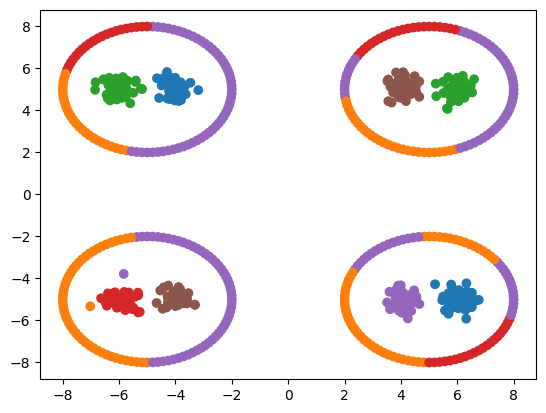

Ground Truth Error is: 454.7118010572375


In [23]:
if(kernelKMeansPP_is_enabled):
    kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=10, init='forgy', verbose=1)
    kernelKMeans.fit()
    
    if graph_is_enabled:
        graph.plot_clusters(kernelKMeans.labels_)
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, kernelKMeans.labels_)
        evaluator.print_evaluation()
        rings.plot(X, kernelKMeans.labels_)

        # That's the function of grount truth error
        ground_truth_error = kernelKMeans.calculate_ground_truth_error(y)
        print(f"Ground Truth Error is: {ground_truth_error}")

### Global Kernel kMeans

In [21]:
K = 3 * len(centers_coordinates)
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=0.8)
if(globalKernelKMeans_is_enabled):
    globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, verbose=1)
    globalKernelKMeans.fit()
    
    if graph_is_enabled:
        graph.plot_clusters(globalKernelKMeans.labels_[K])
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeans.labels_[K])
        evaluator.print_evaluation()
        rings.plot(X, globalKernelKMeans.labels_[K])

Solving Kernel 2-means


KeyboardInterrupt: 

### Global Kernel kMeans++

In [ ]:
K = 3 * len(centers_coordinates)
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)
if(globalKernelKMeansPP_is_enabled):
    globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=10, sampling='batch', verbose=1)
    globalKernelKMeansPP.fit()
    
    if graph_is_enabled:
        graph.plot_clusters(globalKernelKMeansPP.labels_[K])
    else:
        acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
        evaluator.print_evaluation()
        rings.plot(X, globalKernelKMeansPP.labels_[K])